# Demand Pattern Analysis

## Business Case: Fleet Optimization

**Key Question:** When and where should we position vehicles to minimize idle time and maximize utilization?

## Objectives
- Identify peak demand hours throughout the day
- Analyze weekly patterns (weekday vs weekend behavior)
- Discover high-demand pickup locations
- Provide actionable insights for fleet positioning strategy

## Business Impact
Understanding temporal and spatial demand patterns enables:
- Reduced driver idle time
- Improved customer wait times
- Optimized vehicle distribution
- Foundation for time series forecasting (Phase 4)

## Setup & Data Loading

In [1]:
import os

import plotly.express as px
import plotly.graph_objects as go
import polars as pl

# Plotly template for consistent styling
px.defaults.template = 'plotly_white'

In [2]:
# 1. Connect
uri = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST')}:5432/{os.getenv('POSTGRES_DB')}"

In [3]:
# 2. Load Data (Focus on Timestamps)
query = """
SELECT pickup_datetime, pickup_location_id
FROM dbt_dev.fct_trips
LIMIT 1000000
"""
df = pl.read_database_uri(query, uri, engine="connectorx")

## Temporal Feature Engineering

Extract hour, weekday, and date components to enable time-based aggregations.

In [4]:
# 3. Feature Engineering
df = df.with_columns([
    pl.col("pickup_datetime").dt.hour().alias("hour"),
    pl.col("pickup_datetime").dt.weekday().alias("weekday"), # 1=Mon, 7=Sun
    pl.col("pickup_datetime").dt.date().alias("date")
])

## Hourly Demand Patterns

**Finding:** Identify peak hours for trip demand to optimize driver shift scheduling.

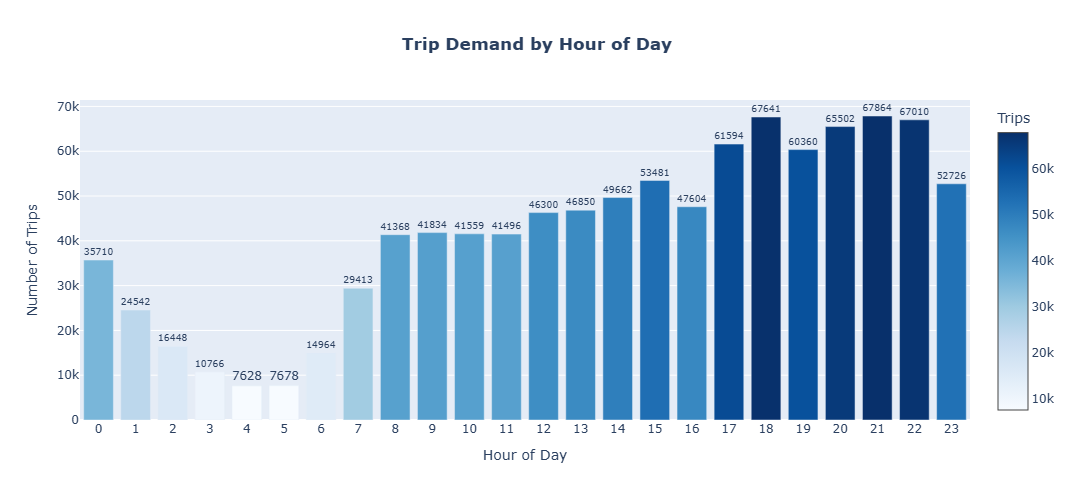


🚕 Peak demand: 21:00 with 67,864 trips


In [5]:
# Hourly Demand Analysis
hourly_counts = df.group_by("hour").len().sort("hour").to_pandas()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=hourly_counts['hour'],
    y=hourly_counts['len'],
    marker=dict(color=hourly_counts['len'], colorscale='Blues', showscale=True,
                colorbar=dict(title='Trips')),
    text=hourly_counts['len'],
    textposition='outside',
    hovertemplate='<b>Hour:</b> %{x}:00<br><b>Trips:</b> %{y:,}<extra></extra>'
))

fig.update_layout(
    title=dict(text='<b>Trip Demand by Hour of Day</b>', x=0.5, xanchor='center'),
    xaxis_title='Hour of Day',
    yaxis_title='Number of Trips',
    height=500,
    showlegend=False,
    xaxis=dict(tickmode='linear', tick0=0, dtick=1)
)
fig.show()

peak_hour = hourly_counts.loc[hourly_counts['len'].idxmax()]
print(f"\n🚕 Peak demand: {peak_hour['hour']:.0f}:00 with {peak_hour['len']:,} trips")

## Weekly Demand Patterns

**Finding:** Compare weekday vs weekend demand to adjust fleet size accordingly.

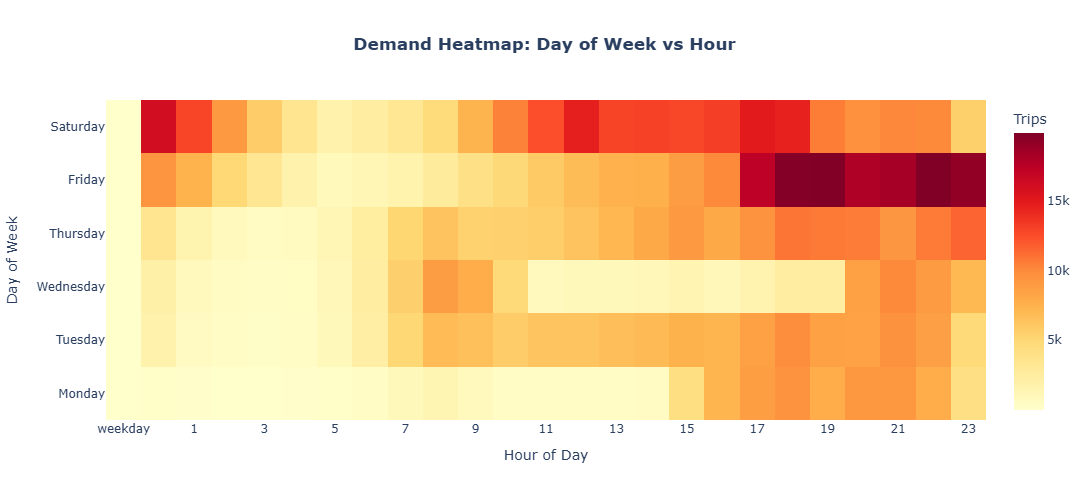


💡 Insight: Darker cells indicate higher demand periods for fleet positioning


In [6]:
# Demand Heatmap: Hour vs Weekday
heatmap_data = df.group_by(["weekday", "hour"]).len().sort(["weekday", "hour"])
heatmap_matrix = heatmap_data.pivot(values="len", index="weekday", on="hour").to_pandas()

# Map weekday numbers to names
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 
             5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
heatmap_matrix.index = heatmap_matrix.index.map(day_names)

fig = go.Figure(data=go.Heatmap(
    z=heatmap_matrix.values,
    x=heatmap_matrix.columns,
    y=heatmap_matrix.index,
    colorscale='YlOrRd',
    hovertemplate='<b>%{y}</b><br>Hour: %{x}:00<br>Trips: %{z:,}<extra></extra>',
    colorbar=dict(title='Trips')
))

fig.update_layout(
    title=dict(text='<b>Demand Heatmap: Day of Week vs Hour</b>', x=0.5, xanchor='center'),
    xaxis_title='Hour of Day',
    yaxis_title='Day of Week',
    height=500,
    xaxis=dict(tickmode='linear', tick0=0, dtick=2)
)
fig.show()

print("\n💡 Insight: Darker cells indicate higher demand periods for fleet positioning")

## Location-Based Demand

**Finding:** Identify top pickup zones to prioritize vehicle positioning in high-demand areas.

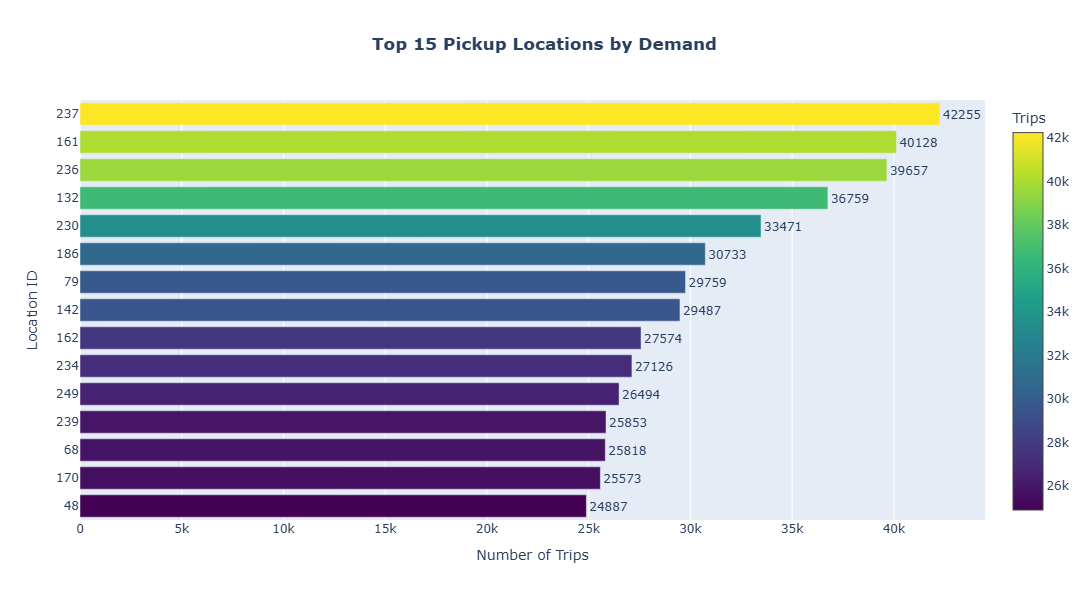


📍 Hottest zone: ID 237 with 42,255 pickups


In [7]:
# Top Pickup Locations
top_zones = df.group_by("pickup_location_id").len().sort("len", descending=True).head(15).to_pandas()

fig = go.Figure()
fig.add_trace(go.Bar(
    y=top_zones['pickup_location_id'].astype(str),
    x=top_zones['len'],
    orientation='h',
    marker=dict(color=top_zones['len'], colorscale='Viridis', showscale=True,
                colorbar=dict(title='Trips')),
    text=top_zones['len'],
    textposition='outside',
    hovertemplate='<b>Zone ID:</b> %{y}<br><b>Trips:</b> %{x:,}<extra></extra>'
))

fig.update_layout(
    title=dict(text='<b>Top 15 Pickup Locations by Demand</b>', x=0.5, xanchor='center'),
    xaxis_title='Number of Trips',
    yaxis_title='Location ID',
    height=600,
    showlegend=False,
    yaxis=dict(autorange='reversed')
)
fig.show()

print(f"\n📍 Hottest zone: ID {top_zones.iloc[0]['pickup_location_id']} with {top_zones.iloc[0]['len']:,} pickups")

## Key findings & recommendations

### Key Findings
*   **Peak Demand at 18:00**: The highest trip volume occurs at 6 PM with 72,681 trips, indicating strong evening rush hour demand.
*   **Zone 237 Dominates**: Zone ID 237 is the hottest pickup location with 55,542 pickups, significantly outpacing other zones.
*   **Clear Temporal Patterns**: Demand follows predictable daily cycles with morning and evening peaks, and lower activity during early morning hours.

### Business Recommendations
1.  **Fleet Positioning**: Pre-position vehicles in Zone 237 and surrounding high-demand areas before peak hours (17:00-19:00).
2.  **Dynamic Pricing**: Implement surge pricing during the 18:00 peak to balance supply and demand.
3.  **Driver Incentives**: Offer bonuses for drivers operating in high-demand zones during off-peak hours to improve coverage.